In [28]:
import numpy as np
from pathlib import Path
import json
import six

from hydra.experimental import compose, initialize_config_dir
# pytorch
import torch
from torch.utils.data import Dataset

# other
import albumentations
from albumentations import KeypointParams
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import lmdb
from PIL import Image

from pose_resnet import get_pose_net
from utils import get_final_preds

EXP_PATH = Path.cwd()
with initialize_config_dir(config_dir=str(EXP_PATH / 'config')):
    cfg = compose(config_name='config.yaml')

ROOT_DIR = Path.cwd().parents[2]
exp_name = EXP_PATH.name
LMDB_DIR = ROOT_DIR / 'data' / cfg.dataset_name / 'lmdb'
SAVE_DIR = ROOT_DIR / 'outputs' / exp_name
SAVE_DIR.mkdir(parents=True, exist_ok=True)

def split_data(cfg, lmdb_dir):
    indices_dict = {}

    env = lmdb.open(str(lmdb_dir), max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
    with env.begin(write=False) as txn:
        n_samples = int(txn.get('num-samples'.encode()))
    
    labels = []
    indices = []
    # check data
    for idx in tqdm(range(n_samples), total=n_samples):
        with env.begin(write=False) as txn:
            # load json
            label_key = f'label-{str(idx+1).zfill(8)}'.encode()
            label = txn.get(label_key).decode('utf-8')
        json_dict = json.loads(label)
        try:
            joints = np.array([[d['x'], d['y']] for d in json_dict['key_point']])
        except:
            continue
        if len(joints) == 0:
            continue
        indices.append(idx)

    print('num-samples: ', len(indices))

    if cfg.split_method == 'KFold':
        for fold, (train_fold_indices, vaild_fold_indices) \
                in enumerate(KFold(n_splits=cfg.n_folds, shuffle=True, random_state=cfg.seed).split(indices)):
            indices_dict[fold] = {
                'train': [indices[i] for i in train_fold_indices],
                'valid': [indices[i] for i in vaild_fold_indices]
            }
    elif cfg.split_method == 'StratifiedKFold':
        for idx in indices:
            with env.begin(write=False) as txn:
                # load json
                label_key = f'label-{str(idx+1).zfill(8)}'.encode()
                label = txn.get(label_key).decode('utf-8')
            json_dict = json.loads(label)
            label = cfg.chart_type2label[json_dict['chart-type']]
            labels.append(label)
        for fold, (train_fold_indices, vaild_fold_indices) \
                in enumerate(StratifiedKFold(n_splits=cfg.n_folds, shuffle=True, random_state=cfg.seed).split(indices, labels)):
            indices_dict[fold] = {
                'train': [indices[i] for i in train_fold_indices],
                'valid': [indices[i] for i in vaild_fold_indices]
            }
    return indices_dict

/Users/nakagawaayato/.local/share/virtualenvs/mga-RYrVM4UM/lib/python3.10/site-packages/hydra/experimental/initialize.py:116: UserWarning: hydra.experimental.initialize_config_dir() is no longer experimental. Use hydra.initialize_config_dir().
  deprecation_warning(message=message)
/Users/nakagawaayato/.local/share/virtualenvs/mga-RYrVM4UM/lib/python3.10/site-packages/hydra/experimental/initialize.py:118: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  self.delegate = real_initialize_config_dir(
/Users/nakagawaayato/.local/share/virtualenvs/mga-RYrVM4UM/lib/python3.10/site-packages/hydra/experimental/compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)


In [29]:
# Lmdb Dataset
class MgaLmdbDataset(Dataset):
    def __init__(self, cfg, lmdb_dir, indices, transforms):
        super().__init__()
        self.cfg = cfg
        self.transforms = transforms
        self.indices = indices
        self.env = lmdb.open(str(lmdb_dir), max_readers=32, readonly=True, lock=False, readahead=False, meminit=False)
        self.n_joints = cfg.output_size
        self.sigma = cfg.sigma
        self.img_h, self.img_w = cfg.img_h, cfg.img_w
        self.heatmap_h, self.heatmap_w = cfg.heatmap_h, cfg.heatmap_w

    def _create_heatmap(self, joints):
        '''
            joints: [(x1, y1), (x2, y2), ...]
            heatmap: size: (n_joints, hm_h, hm_w)
        '''
        heatmap = np.zeros((self.n_joints, self.heatmap_h, self.heatmap_w), dtype=np.float32)
        for joint_id in range(len(joints)):
            mu_x = joints[joint_id][0]
            mu_y = joints[joint_id][1]
            
            x = np.arange(0, self.heatmap_w, 1, np.float32)
            y = np.arange(0, self.heatmap_h, 1, np.float32)
            y = y[:, np.newaxis]

            heatmap[joint_id] = np.exp(- ((x - mu_x) ** 2 + (y - mu_y) ** 2) / (2 * self.sigma ** 2))
        return heatmap
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        idx = self.indices[idx]
        with self.env.begin(write=False) as txn:
            # load image
            img_key = f'image-{str(idx+1).zfill(8)}'.encode()
            imgbuf = txn.get(img_key)

            # load json
            label_key = f'label-{str(idx+1).zfill(8)}'.encode()
            label = txn.get(label_key).decode('utf-8')
        
        # image        
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)
        if self.cfg.input_size == 3:
            img = np.array(Image.open(buf).convert('RGB'))
        else:
            img = np.array(Image.open(buf).convert('L'))
        
        # label
        json_dict = json.loads(label)
        keypoints = [[dic['x'], dic['y']] for dic in json_dict['key_point']]
        kp_arr = np.array(keypoints)
        kp_min = np.amin(kp_arr, 0)
        if kp_min[0] < 0 or kp_min[1] < 0:
            print(json_dict['id'])

        transformed = self.transforms(image=img, keypoints=keypoints)
        img = transformed['image']
        keypoints = transformed['keypoints']
        keypoints_on_hm = np.array(keypoints) * \
            np.array([self.heatmap_w, self.heatmap_h]) / np.array([self.img_w, self.img_h])

        heatmap_weight = np.zeros(self.n_joints, dtype=np.int32)
        heatmap_weight[:len(keypoints)] = 1

        heatmap = self._create_heatmap(keypoints_on_hm)

        img = torch.from_numpy(img).permute(2, 0, 1)
        heatmap = torch.from_numpy(heatmap)
        heatmap_weight = torch.from_numpy(heatmap_weight)

        return img, heatmap, heatmap_weight

In [30]:
def get_transforms(cfg, phase):
    if phase == 'train':
        aug = cfg.train_aug
    elif phase == 'valid':
        aug = cfg.valid_aug
    elif phase == 'tta':
        aug = cfg.tta_aug

    augs = [getattr(albumentations, name)(**kwargs) for name, kwargs in aug.items()]
    # augs.append(ToTensorV2(p=1.))
    return albumentations.Compose(augs, keypoint_params=KeypointParams(format='xy'))

In [31]:
ds = MgaLmdbDataset(cfg, LMDB_DIR, list(range(300)), get_transforms(cfg, 'train'))

In [93]:
img, hm, hm_weight = ds.__getitem__(12)

In [94]:
model = get_pose_net(cfg.output_size)

In [95]:
hm_preds = model(img.unsqueeze(0)).detach().cpu().numpy()

In [96]:
coor, v = get_final_preds(cfg, hm_preds)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


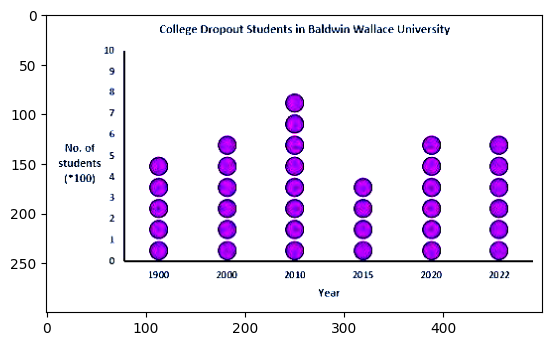

In [97]:
plt.imshow(img.permute(1, 2, 0).detach().cpu().numpy())

In [98]:
p = np.zeros_like(hm_preds[0, 0, :, :])

In [99]:
p.shape

(80, 128)

In [100]:
for i, (x, y) in enumerate(coor[0]):
    try:
        p[int(y)][int(x)] = v[0, i, 0]
    except:
        pass

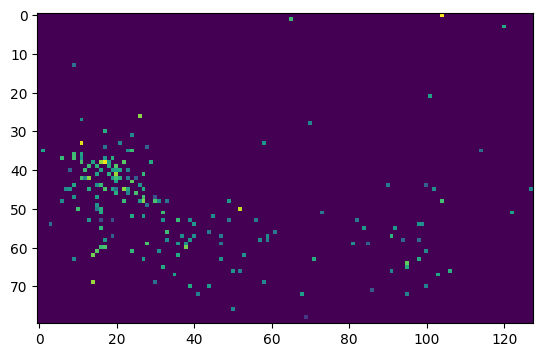

In [101]:
plt.imshow(p)

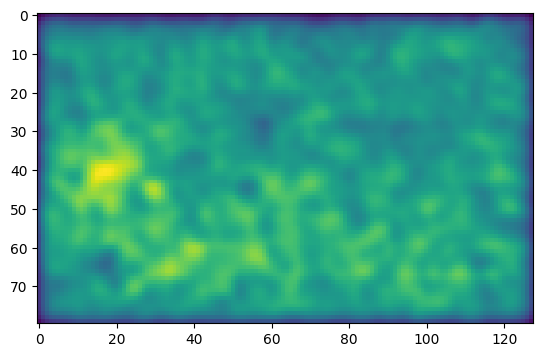

In [105]:
plt.imshow(hm_preds[0, 3, :, :])